In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 6.5 MB/s 
     |████████████████████████████████| 3.5 MB 9.7 MB/s 


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
Explainability_name = 'ExcitationBP'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [ ]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [ ]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [ ]:
dataset2 = balanced_train_test_split(dataset)
dataset_EB = dataset2[0]
print(dataset_EB)
print(len(dataset_EB))
print(len(dataset_EB.x[dataset_EB.train_mask]))
print(len(dataset_EB.x[dataset_EB.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [ ]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [ ]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [ ]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [ ]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [ ]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return out, post_conv2, post_conv1

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

In [ ]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out, post_conv2, post_conv1 = GCN_Model(dataset_EB.x, dataset_EB.edge_index)
#visualize(out, color=data.y)


GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(100, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_EB.x, dataset_EB.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_EB.train_mask], dataset_EB.y[dataset_EB.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, ExcitationBP Model Loss: 1.9459
Epoch: 002, ExcitationBP Model Loss: 1.9435
Epoch: 003, ExcitationBP Model Loss: 1.9395
Epoch: 004, ExcitationBP Model Loss: 1.9313
Epoch: 005, ExcitationBP Model Loss: 1.9167
Epoch: 006, ExcitationBP Model Loss: 1.8928
Epoch: 007, ExcitationBP Model Loss: 1.8574
Epoch: 008, ExcitationBP Model Loss: 1.8106
Epoch: 009, ExcitationBP Model Loss: 1.7586
Epoch: 010, ExcitationBP Model Loss: 1.7111
Epoch: 011, ExcitationBP Model Loss: 1.6695
Epoch: 012, ExcitationBP Model Loss: 1.6176
Epoch: 013, ExcitationBP Model Loss: 1.5506
Epoch: 014, ExcitationBP Model Loss: 1.4823
Epoch: 015, ExcitationBP Model Loss: 1.4249
Epoch: 016, ExcitationBP Model Loss: 1.3734
Epoch: 017, ExcitationBP Model Loss: 1.3142
Epoch: 018, ExcitationBP Model Loss: 1.2492
Epoch: 019, ExcitationBP Model Loss: 1.1885
Epoch: 020, ExcitationBP Model Loss: 1.1338
Epoch: 021, ExcitationBP Model Loss: 1.0779
Epoch: 022, ExcitationBP Model Loss: 1.0206
Epoch: 023, ExcitationBP Model L

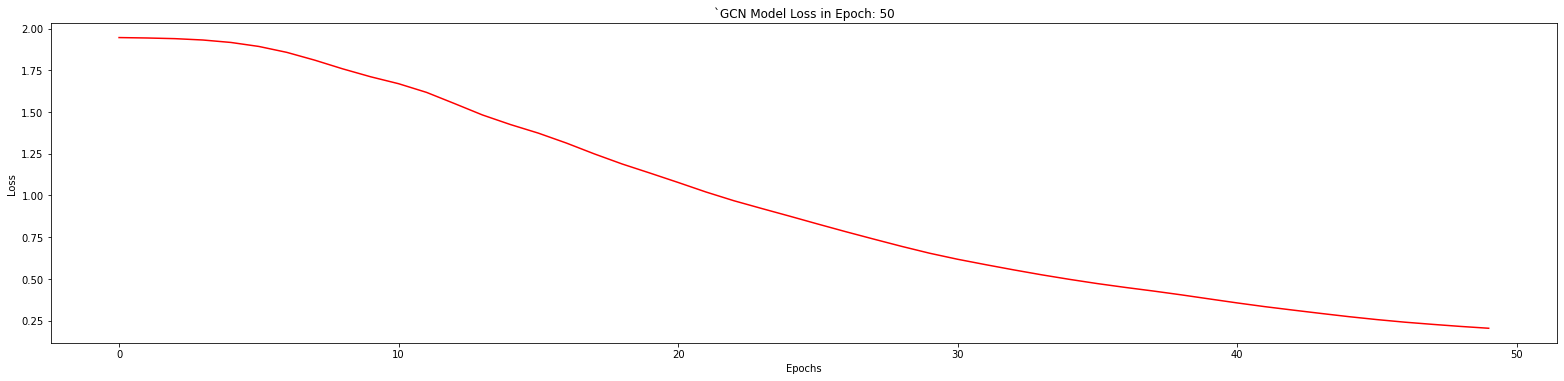

Epoch: 051, ExcitationBP Model Loss: 0.1953
Epoch: 052, ExcitationBP Model Loss: 0.1876
Epoch: 053, ExcitationBP Model Loss: 0.1811
Epoch: 054, ExcitationBP Model Loss: 0.1750
Epoch: 055, ExcitationBP Model Loss: 0.1698
Epoch: 056, ExcitationBP Model Loss: 0.1655
Epoch: 057, ExcitationBP Model Loss: 0.1620
Epoch: 058, ExcitationBP Model Loss: 0.1587
Epoch: 059, ExcitationBP Model Loss: 0.1559
Epoch: 060, ExcitationBP Model Loss: 0.1536
Epoch: 061, ExcitationBP Model Loss: 0.1518
Epoch: 062, ExcitationBP Model Loss: 0.1503
Epoch: 063, ExcitationBP Model Loss: 0.1489
Epoch: 064, ExcitationBP Model Loss: 0.1478
Epoch: 065, ExcitationBP Model Loss: 0.1468
Epoch: 066, ExcitationBP Model Loss: 0.1459
Epoch: 067, ExcitationBP Model Loss: 0.1450
Epoch: 068, ExcitationBP Model Loss: 0.1441
Epoch: 069, ExcitationBP Model Loss: 0.1432
Epoch: 070, ExcitationBP Model Loss: 0.1423
Epoch: 071, ExcitationBP Model Loss: 0.1413
Epoch: 072, ExcitationBP Model Loss: 0.1403
Epoch: 073, ExcitationBP Model L

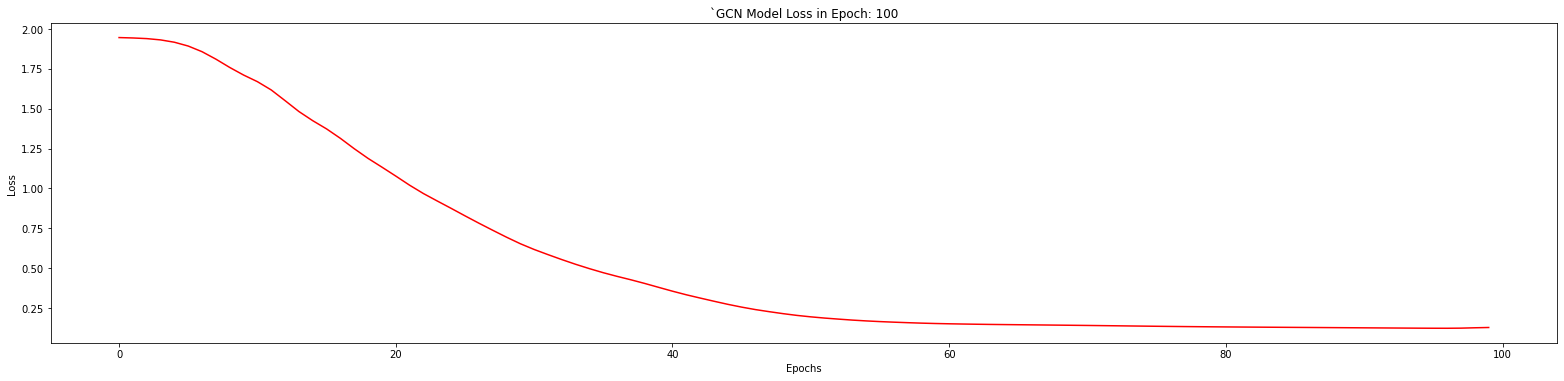

Epoch: 101, ExcitationBP Model Loss: 0.1240
Epoch: 102, ExcitationBP Model Loss: 0.1210
Epoch: 103, ExcitationBP Model Loss: 0.1240
Epoch: 104, ExcitationBP Model Loss: 0.1221
Epoch: 105, ExcitationBP Model Loss: 0.1192
Epoch: 106, ExcitationBP Model Loss: 0.1217
Epoch: 107, ExcitationBP Model Loss: 0.1202
Epoch: 108, ExcitationBP Model Loss: 0.1184
Epoch: 109, ExcitationBP Model Loss: 0.1203
Epoch: 110, ExcitationBP Model Loss: 0.1188
Epoch: 111, ExcitationBP Model Loss: 0.1177
Epoch: 112, ExcitationBP Model Loss: 0.1191
Epoch: 113, ExcitationBP Model Loss: 0.1176
Epoch: 114, ExcitationBP Model Loss: 0.1169
Epoch: 115, ExcitationBP Model Loss: 0.1178
Epoch: 116, ExcitationBP Model Loss: 0.1165
Epoch: 117, ExcitationBP Model Loss: 0.1160
Epoch: 118, ExcitationBP Model Loss: 0.1165
Epoch: 119, ExcitationBP Model Loss: 0.1154
Epoch: 120, ExcitationBP Model Loss: 0.1150
Epoch: 121, ExcitationBP Model Loss: 0.1153
Epoch: 122, ExcitationBP Model Loss: 0.1144
Epoch: 123, ExcitationBP Model L

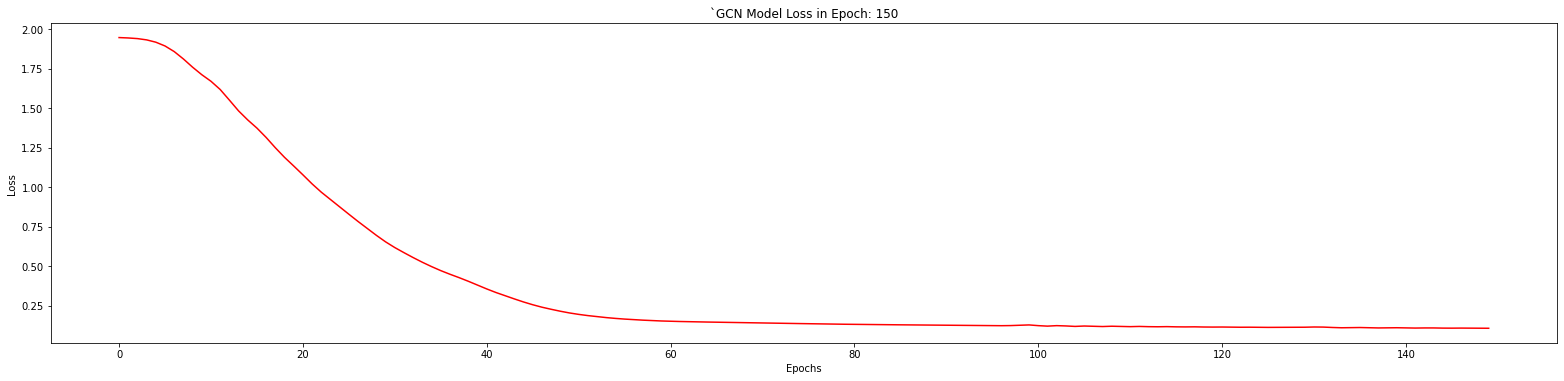

Epoch: 151, ExcitationBP Model Loss: 0.1075
Epoch: 152, ExcitationBP Model Loss: 0.1072
Epoch: 153, ExcitationBP Model Loss: 0.1068
Epoch: 154, ExcitationBP Model Loss: 0.1066
Epoch: 155, ExcitationBP Model Loss: 0.1065
Epoch: 156, ExcitationBP Model Loss: 0.1062
Epoch: 157, ExcitationBP Model Loss: 0.1060
Epoch: 158, ExcitationBP Model Loss: 0.1059
Epoch: 159, ExcitationBP Model Loss: 0.1056
Epoch: 160, ExcitationBP Model Loss: 0.1053
Epoch: 161, ExcitationBP Model Loss: 0.1051
Epoch: 162, ExcitationBP Model Loss: 0.1050
Epoch: 163, ExcitationBP Model Loss: 0.1050
Epoch: 164, ExcitationBP Model Loss: 0.1047
Epoch: 165, ExcitationBP Model Loss: 0.1044
Epoch: 166, ExcitationBP Model Loss: 0.1042
Epoch: 167, ExcitationBP Model Loss: 0.1040
Epoch: 168, ExcitationBP Model Loss: 0.1039
Epoch: 169, ExcitationBP Model Loss: 0.1037
Epoch: 170, ExcitationBP Model Loss: 0.1035
Epoch: 171, ExcitationBP Model Loss: 0.1033
Epoch: 172, ExcitationBP Model Loss: 0.1032
Epoch: 173, ExcitationBP Model L

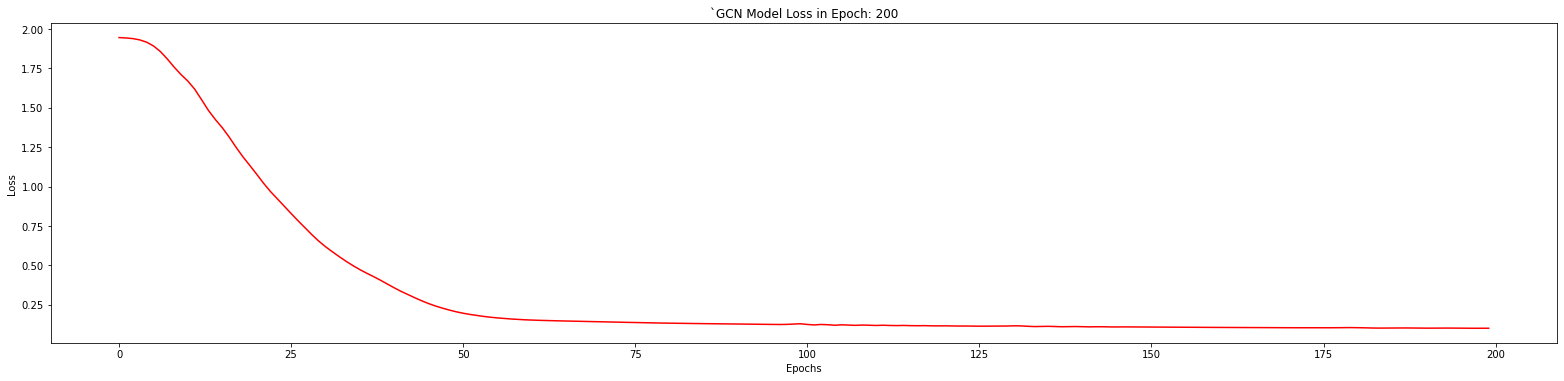

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_EB.x, dataset_EB.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_EB.test_mask] == dataset_EB.y[dataset_EB.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_EB.test_mask.sum())
  return GCN_Model_test_acc

In [ ]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8678


In [ ]:
GCN_Model.eval()

GCN_Model_test_out, post_conv2, post_conv1 = GCN_Model(dataset_EB.x, dataset_EB.edge_index)
#visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

## **Excitation BackPropagation**

In [ ]:
GCN_Model_state = GCN_Model.state_dict()
print(GCN_Model_state.keys())

odict_keys(['gconv1.weight', 'gconv1.lin.weight', 'gconv2.weight', 'gconv2.lin.weight', 'ffn.weight'])


In [ ]:
print(GCN_Model.gconv1.weight.detach().clone().shape)

torch.Size([1433, 100])


In [ ]:
def GCN_Model_EB(dataset):
  GCN_Model.eval()
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset.x, dataset.edge_index)
  return GCN_Model_out.detach().tolist(), post_conv2.detach().tolist(), post_conv1.detach().tolist()

# **Activations**

In [ ]:
FFN_activations, GConv2_activations, GConv1_activations = GCN_Model_EB(dataset_EB)
print(np.shape(FFN_activations))
print(np.shape(GConv2_activations))
print(np.shape(GConv1_activations))

(2708, 7)
(2708, 100)
(2708, 100)


In [ ]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

2708
100


In [ ]:
def accumulate_weights(model_for_you):

  #gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
  gconv1_weight = model_for_you.gconv1.weight.detach().tolist()

  #gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
  gconv2_weight = model_for_you.gconv2.weight.detach().tolist()

  #ffn_bias = model_for_you.ffn.bias.detach().tolist()
  ffn_weight = model_for_you.ffn.weight.detach().tolist()

  

  #return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias
  return gconv1_weight, gconv2_weight, ffn_weight

In [ ]:
#GConv1_weight, GConv1_bias, GConv2_weight, GConv2_bias, FFN_weight, FFN_bias = accumulate_weights(GCN_Model)
GConv1_weight, GConv2_weight, FFN_weight = accumulate_weights(GCN_Model)

# **Weights' shape**

In [ ]:
print(np.shape(FFN_weight))
print(np.shape(GConv2_weight))
print(np.shape(GConv1_weight))

(7, 100)
(100, 100)
(1433, 100)


In [ ]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))

(100, 1433)


In [ ]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))

(100, 100)


In [ ]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(100, 7)


In [ ]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

# **Transposed Weights**

In [ ]:
print(np.shape(FFN_weight_T))
print(np.shape(GConv2_weight_T))
print(np.shape(GConv1_weight_T))

(100, 7)
(100, 100)
(100, 1433)


In [ ]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)

[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [ ]:
def my_relu(input):
  return np.maximum(0, input)
print(my_relu([0,1,2,3,4,-1,-2,-4,-6]))
print(my_relu(-1))

[0 1 2 3 4 0 0 0 0]
0


In [ ]:
def Compute_P_last_layer(FFN_activations):
  last_layer_R_k = [0] * len(FFN_activations)
  last_layer_R_k[FFN_activations.index(max(FFN_activations))] = 1
  return last_layer_R_k

In [ ]:
def Division_by_Zero(epsilon, act_hat):
  for i in range(len(act_hat)):
    if act_hat[i] == 0:
      act_hat[i] = act_hat[i] + epsilon
    else:
      act_hat[i] = act_hat[i]
  return act_hat

In [ ]:
def Compute_Pobabilities(epsilon, preceding_layer_activations, exceding_layer_weights, exceding_layer_prob):
  #print("preceding layer activations: ", np.shape(preceding_layer_activations))
  #print("exceding layer weights: ", np.shape(exceding_layer_weights))
  #print("exceding layer probabilities: ", np.shape(exceding_layer_prob))
  #Division_by_Zero(exceding_layer_weights, preceding_layer_activations)

  # 1 Weights and Activations
  weights_and_activations = []
  for i in range(len(exceding_layer_weights)):
    weights_and_activations.append(sum([x*y for x,y in zip(my_relu(exceding_layer_weights[i]), preceding_layer_activations)]))
  
  weights_and_activations = Division_by_Zero(epsilon, weights_and_activations)

  # 2 Point-Wise division
  division_result = [exceding_layer_prob[i]/ weights_and_activations[i] for i in range(len(exceding_layer_prob))]
  #print(np.shape(division_result))


  # 3 Multiplication by Weights
  exceding_layer_weights = np.array(exceding_layer_weights).transpose()
  exceding_layer_weights = exceding_layer_weights.tolist()

  weights_third_step = []
  for i in range(len(exceding_layer_weights)):
    weights_third_step.append(sum([x*y for x,y in zip(my_relu(exceding_layer_weights[i]), division_result)]))
  #print(np.shape(weights_third_step))

  # 4 Forth Step
  final_probability_vector = [preceding_layer_activations[i] * weights_third_step[i] for i in range(len(preceding_layer_activations))]
  #print(np.shape(final_probability_vector))
  return final_probability_vector

In [ ]:
def One_Sample_EB(epsilon, input_sample, weights, activations):
  GConv1_weight = weights[0]
  GConv1_weight_T = weights[1]

  GConv2_weight = weights[2]
  GConv2_weight_T = weights[3]

  FFN_weight = weights[4]
  FFN_weight_T = weights[5]

  GConv1_activations = activations[0]
  GConv2_activations = activations[1]
  FFN_activations = activations[2]


  last_layer_prob = Compute_P_last_layer(FFN_activations)


  hidden2_probability_vector = Compute_Pobabilities(epsilon, GConv2_activations, FFN_weight, last_layer_prob)
  #print("Probability: ",hidden2_probability_vector)
  #print(len(hidden2_probability_vector))

  hidden1_probability_vector = Compute_Pobabilities(epsilon, GConv1_activations, GConv2_weight_T, hidden2_probability_vector)
  #print("Probability: ",hidden2_probability_vector)
  #print(len(hidden2_probability_vector))

  input_probability_vector = Compute_Pobabilities(epsilon, input_sample, GConv1_weight_T, hidden1_probability_vector)
  #print("Probability: ",input_probability_vector)
  #print(len(input_probability_vector))
  
  
  return input_probability_vector

In [ ]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(1433, 100) (100, 100) (100, 7)
(100, 1433) (100, 100) (7, 100)


In [ ]:
print(np.shape(dataset_EB.x), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([2708, 1433]) (2708, 100) (2708, 100) (2708, 7)


In [ ]:
sample = 0
epsilon = 1e-16
EB = One_Sample_EB(epsilon, dataset_EB.x[sample].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[sample], GConv2_activations[sample], FFN_activations[sample]])

In [ ]:
def MWP_Node_Features(eb, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Marginal Winning Probability generated for sample: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")
  
  ax1.plot(eb, color='r')
  print('done')
  
  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Marginal Winning Probability generated for sample number: " + str(sample) + ".png")
  plt.show()

done


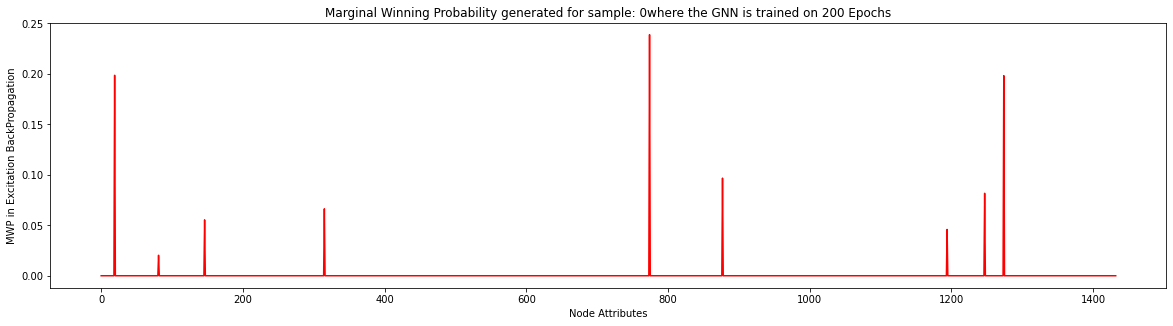

In [ ]:
MWP_Node_Features(EB, sample)

## **Class based averaging on MWP**

In [ ]:
Train_Index_List = []
for i in range(len(dataset_EB.train_mask)):
  if dataset_EB.train_mask[i]:
    Train_Index_List.append(i)

Test_Index_List = []
for i in range(len(dataset_EB.test_mask)):
  if dataset_EB.test_mask[i]:
    Test_Index_List.append(i)

In [ ]:
Node_Index_Class1 = []
Node_Index_Class2 = []
Node_Index_Class3 = []
Node_Index_Class4 = []
Node_Index_Class5 = []
Node_Index_Class6 = []
Node_Index_Class7 = []

In [ ]:
for i in range(len(Test_Index_List)):
  if dataset_EB.y[Test_Index_List[i]] == 0:
    Node_Index_Class1.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 1:
    Node_Index_Class2.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 2:
    Node_Index_Class3.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 3:
    Node_Index_Class4.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 4:
    Node_Index_Class5.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 5:
    Node_Index_Class6.append(Test_Index_List[i])
  elif dataset_EB.y[Test_Index_List[i]] == 6:
    Node_Index_Class7.append(Test_Index_List[i])

In [ ]:
print(len(Node_Index_Class1), len(Node_Index_Class2), len(Node_Index_Class3), len(Node_Index_Class4), len(Node_Index_Class5), len(Node_Index_Class6), len(Node_Index_Class7))

106 66 126 246 128 90 55


## **EB of samples in each Class**

In [ ]:
EBs_Class1 = []
for index in Node_Index_Class1:
  EBs_Class1.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class1))
print(len(EBs_Class1[0]))
print(EBs_Class1[0])
print(np.shape(EBs_Class1))

106
1433
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08532617975884389, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
EBs_Class2 = []
for index in Node_Index_Class2:
  EBs_Class2.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class2))
print(len(EBs_Class2[0]))
print(EBs_Class2[0])
print(np.shape(EBs_Class2))

66
1433
[0.0, 0.0, 0.0, 0.016802403653664914, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
EBs_Class3 = []
for index in Node_Index_Class3:
  EBs_Class3.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class3))
print(len(EBs_Class3[0]))
print(EBs_Class3[0])
print(np.shape(EBs_Class3))

126
1433
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10934232743360943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11328127575853612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
EBs_Class4 = []
for index in Node_Index_Class4:
  EBs_Class4.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class4))
print(len(EBs_Class4[0]))
print(EBs_Class4[0])
print(np.shape(EBs_Class4))

246
1433
[0.0, 0.0, 0.0, 0.010809611493610833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03936181912378562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
EBs_Class5 = []
for index in Node_Index_Class5:
  EBs_Class5.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class5))
print(len(EBs_Class5[0]))
print(EBs_Class5[0])
print(np.shape(EBs_Class5))

128
1433
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4302895344701519, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
EBs_Class6 = []
for index in Node_Index_Class6:
  EBs_Class6.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class6))
print(len(EBs_Class6[0]))
print(EBs_Class6[0])
print(np.shape(EBs_Class6))

90
1433
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005833747507723555, 0.0, 0.0, 0.0, 0.031757810486459925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011389668834508348, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
EBs_Class7 = []
for index in Node_Index_Class7:
  EBs_Class7.append(One_Sample_EB(epsilon, dataset_EB.x[index].detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[index], GConv2_activations[index], FFN_activations[index]]))

In [ ]:
print(len(EBs_Class7))
print(len(EBs_Class7[0]))
print(EBs_Class7[0])
print(np.shape(EBs_Class7))

55
1433
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08148601750048837, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
print(len(EBs_Class1), len(EBs_Class2), len(EBs_Class3), len(EBs_Class4), len(EBs_Class5), len(EBs_Class6), len(EBs_Class7))

106 66 126 246 128 90 55


## **Average Relevances in all Classes**

In [ ]:
Average_EBs_Class1 = np.mean(EBs_Class1, axis=0)
Average_EBs_Class2 = np.mean(EBs_Class2, axis=0)
Average_EBs_Class3 = np.mean(EBs_Class3, axis=0)
Average_EBs_Class4 = np.mean(EBs_Class4, axis=0)
Average_EBs_Class5 = np.mean(EBs_Class5, axis=0)
Average_EBs_Class6 = np.mean(EBs_Class6, axis=0)
Average_EBs_Class7 = np.mean(EBs_Class7, axis=0)

## **PLOT Average Relevances**

In [ ]:
def Averaged_Excitation_Classes(EB):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs") 

  ax3 = plt.subplot2grid((7, 1), (2, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Three, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax4 = plt.subplot2grid((7, 1), (3, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Four, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax5 = plt.subplot2grid((7, 1), (4, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Five, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax6 = plt.subplot2grid((7, 1), (5, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Six, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax7 = plt.subplot2grid((7, 1), (6, 0), colspan=7)
  plt.xlabel("Nodes' Attributes")
  plt.ylabel('MWP in Excitation BackPropagation')
  plt.title("Dimensionally Averaged Excitations for Class: Seven, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(EB[0], color='r')
  ax2.plot(EB[1], color='r')
  ax3.plot(EB[2], color='r')
  ax4.plot(EB[3], color='r')
  ax5.plot(EB[4], color='r')
  ax6.plot(EB[5], color='r')
  ax7.plot(EB[6], color='r')  

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged Excitations for Classes.png")
  plt.show()

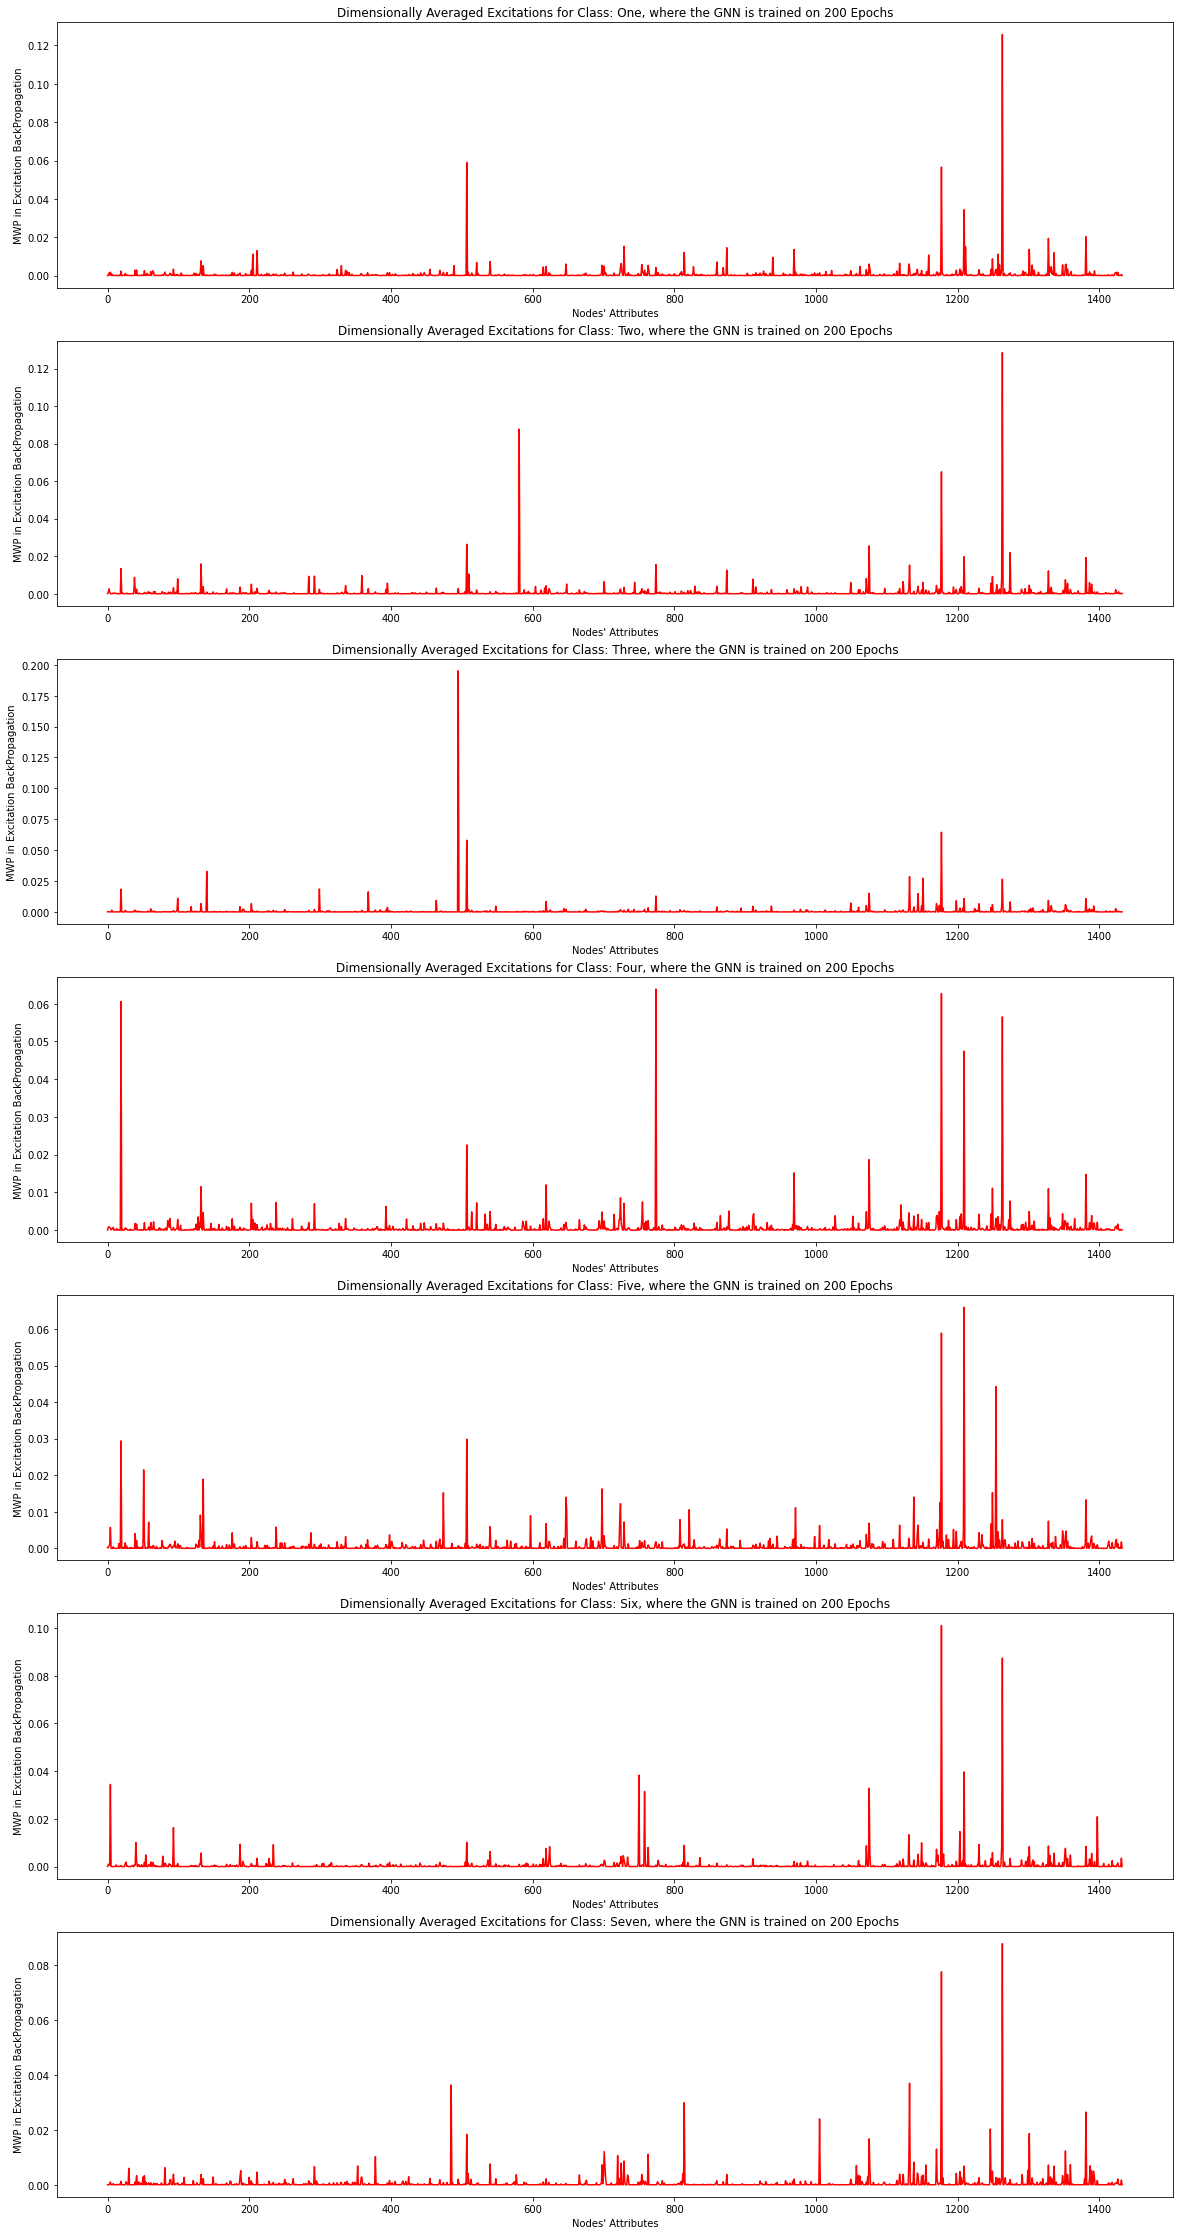

In [ ]:
Averaged_Excitation_Classes([Average_EBs_Class1, Average_EBs_Class2, Average_EBs_Class3, Average_EBs_Class4, Average_EBs_Class5, Average_EBs_Class6, Average_EBs_Class7])